# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -0.2 * x
mu = -x + x**2
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

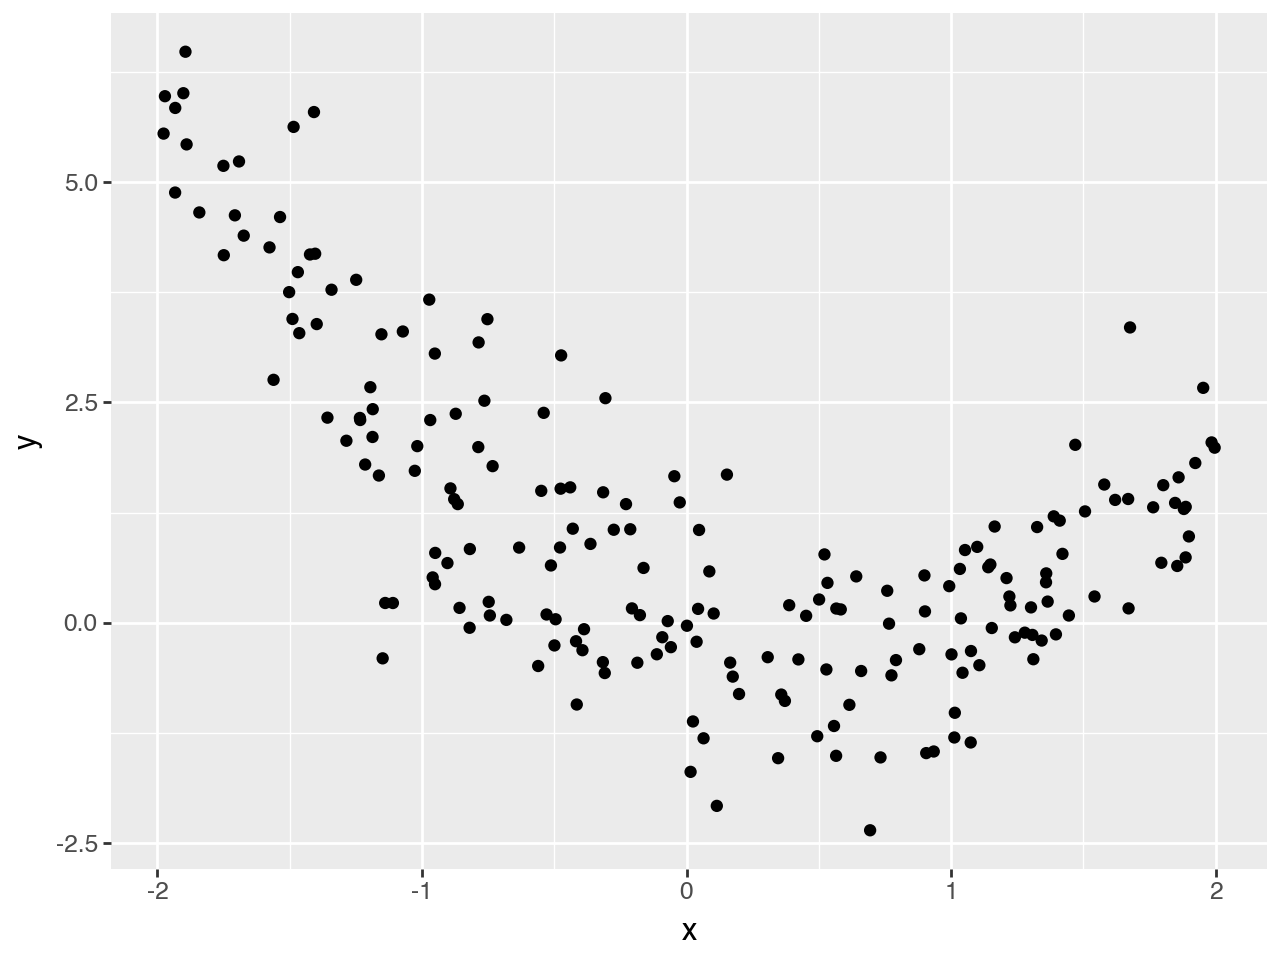

In [3]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

### Setup response model

In [4]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [5]:
tb = gam.TermBuilder.from_df(df)

In [6]:
loc += tb.lin("x + {x**2}")
scale += tb.lin("x")

### Build and plot model

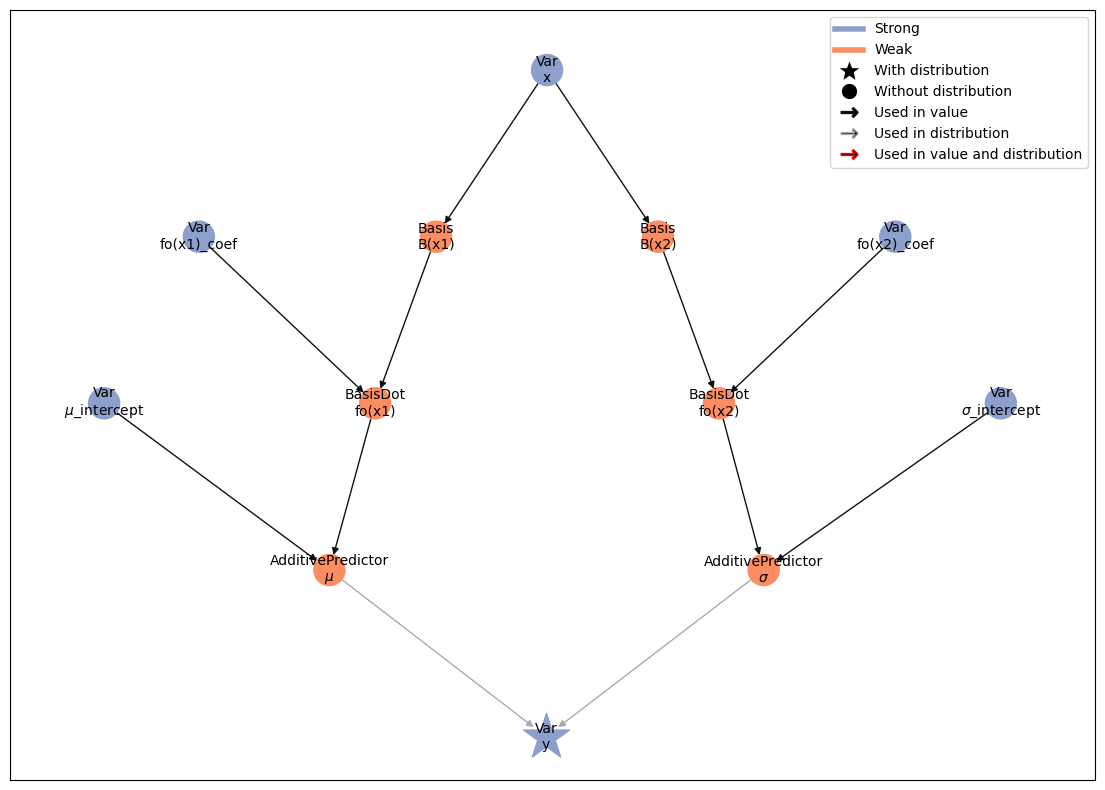

In [7]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [8]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', 'fo(x2)_coef', '$\\mu$_intercept', 'fo(x1)_coef'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:03<00:00,  5.22chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1213.63chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1774.62chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epo

### MCMC summary

In [9]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel      mean        sd    q_0.05     q_0.5  \
parameter          index                                                      
$\mu$_intercept    ()     kernel_02 -0.119089  0.095291 -0.281068 -0.117910   
$\sigma$_intercept ()     kernel_00 -0.100286  0.050632 -0.183473 -0.101233   
fo(x1)_coef        (0,)   kernel_03 -1.027187  0.062319 -1.129189 -1.028009   
                   (1,)   kernel_03  1.031782  0.057078  0.938339  1.032346   
fo(x2)_coef        (0,)   kernel_01 -0.139693  0.050321 -0.223615 -0.139663   

                            q_0.95  sample_size     ess_bulk     ess_tail  \
parameter          index                                                    
$\mu$_intercept    ()     0.037929         4000  3460.664194  3889.011429   
$\sigma$_intercept ()    -0.014503         4000  3623.195921  3926.220573   
fo(x1)_coef        (0,)  -0.924141         4000  3725.072277  3638.132142   
                   (1,)   1.124564         4000  3309.894034  3434.940686   
fo(x2)_coef        (0,)  -0.057991         4000  4079.104043  3814.357189   

                              rhat  
parameter          index            
$\mu$_intercept    ()     1.000877  
$\sigma$_intercept ()     1.000469  
fo(x1)_coef        (0,)   1.000392  
                   (1,)   1.000675  
fo(x2)_coef        (0,)   1.000512

### MCMC trace plots

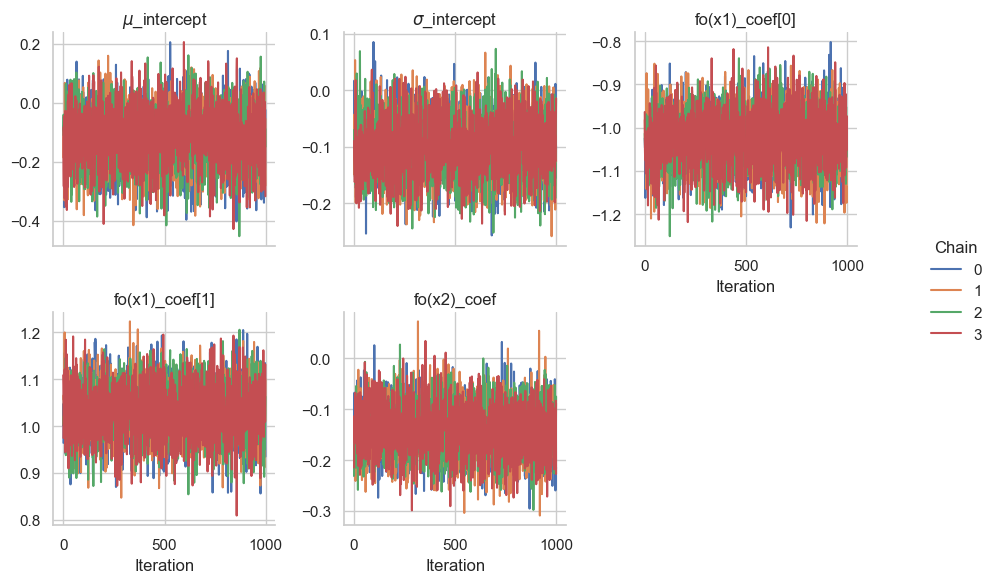

In [10]:
gs.plot_trace(results)

## Predictions

In [11]:
samples = results.get_posterior_samples()

### Predict variables at new x values

In [12]:
x_grid = jnp.linspace(x.min(), x.max(), 300)
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["fo(x1)", "fo(x2)", "$\\mu$", "$\\sigma$"],
    newdata={"x": x_grid},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["x"] = np.tile(x_grid, len(predictions))

In [13]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,ess_bulk,ess_tail,mcse_mean,mcse_sd,rhat,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x
0,$\mu$,$\mu$[0],"(0,)",4000,5.942883,0.062123,0.249245,3509.415676,3917.425800,0.004200,0.002820,1.000015,5.525084,5.946635,6.360636,5.517810,6.344121,-1.976702
1,$\mu$,$\mu$[1],"(1,)",4000,5.875216,0.060618,0.246207,3511.729320,3620.340102,0.004147,0.002786,1.000012,5.462891,5.879130,6.289620,5.454056,6.270730,-1.963415
2,$\mu$,$\mu$[2],"(2,)",4000,5.807920,0.059143,0.243193,3513.967391,3803.655019,0.004094,0.002752,1.000012,5.401111,5.811392,6.216728,5.386973,6.193907,-1.950128
3,$\mu$,$\mu$[3],"(3,)",4000,5.740976,0.057698,0.240204,3517.690636,3864.148710,0.004041,0.002719,1.000007,5.339291,5.744456,6.143470,5.319619,6.116711,-1.936841
4,$\mu$,$\mu$[4],"(4,)",4000,5.674407,0.056283,0.237240,3523.207000,4028.219448,0.003989,0.002686,1.000005,5.278539,5.677839,6.072491,5.258993,6.045969,-1.923554


### Plot fitted functions

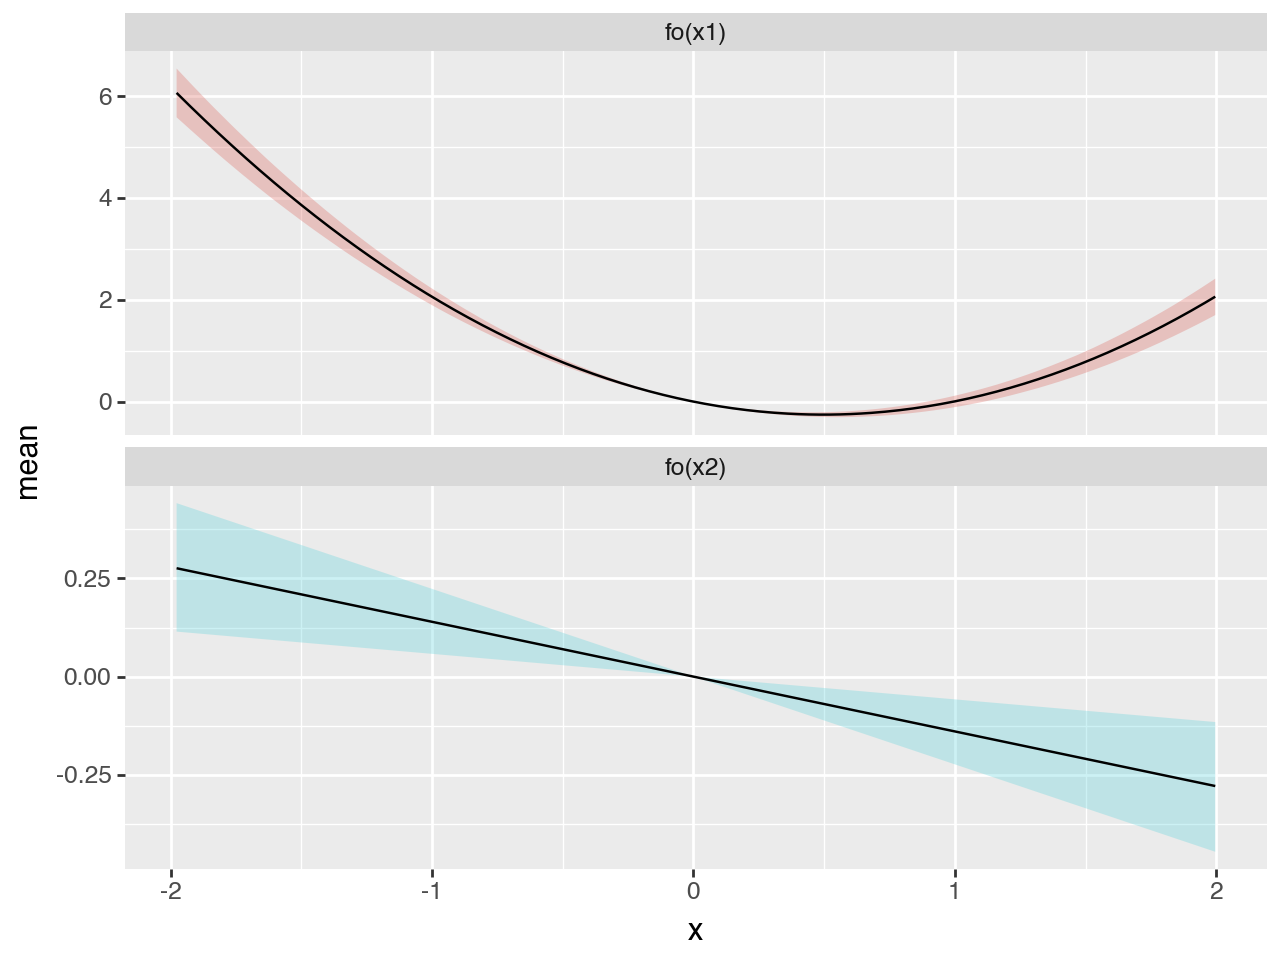

In [14]:
select = predictions_summary["variable"].isin(["fo(x2)", "fo(x1)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot parameters as functions of covariate

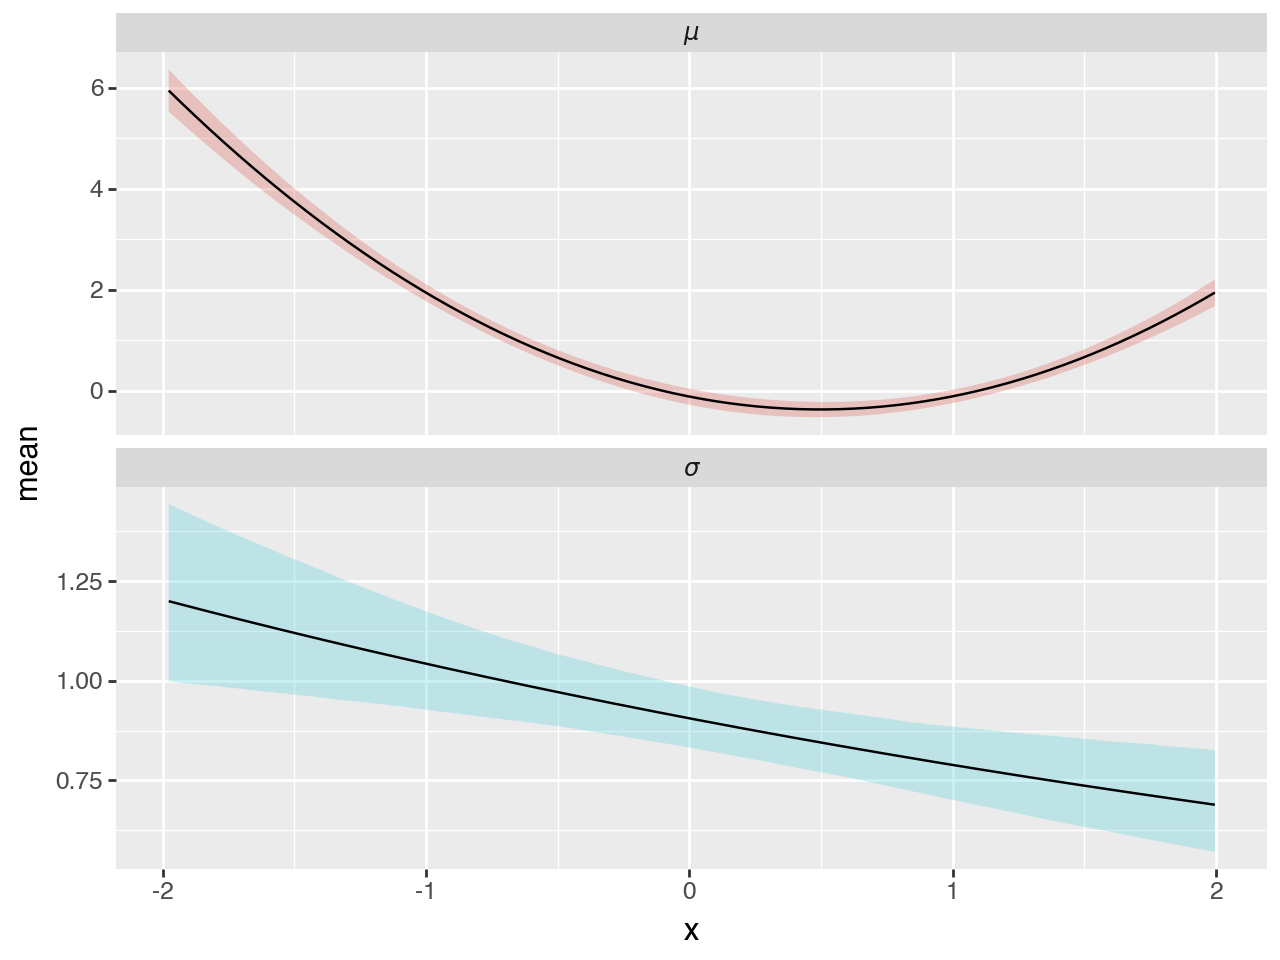

In [15]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot mean function with data

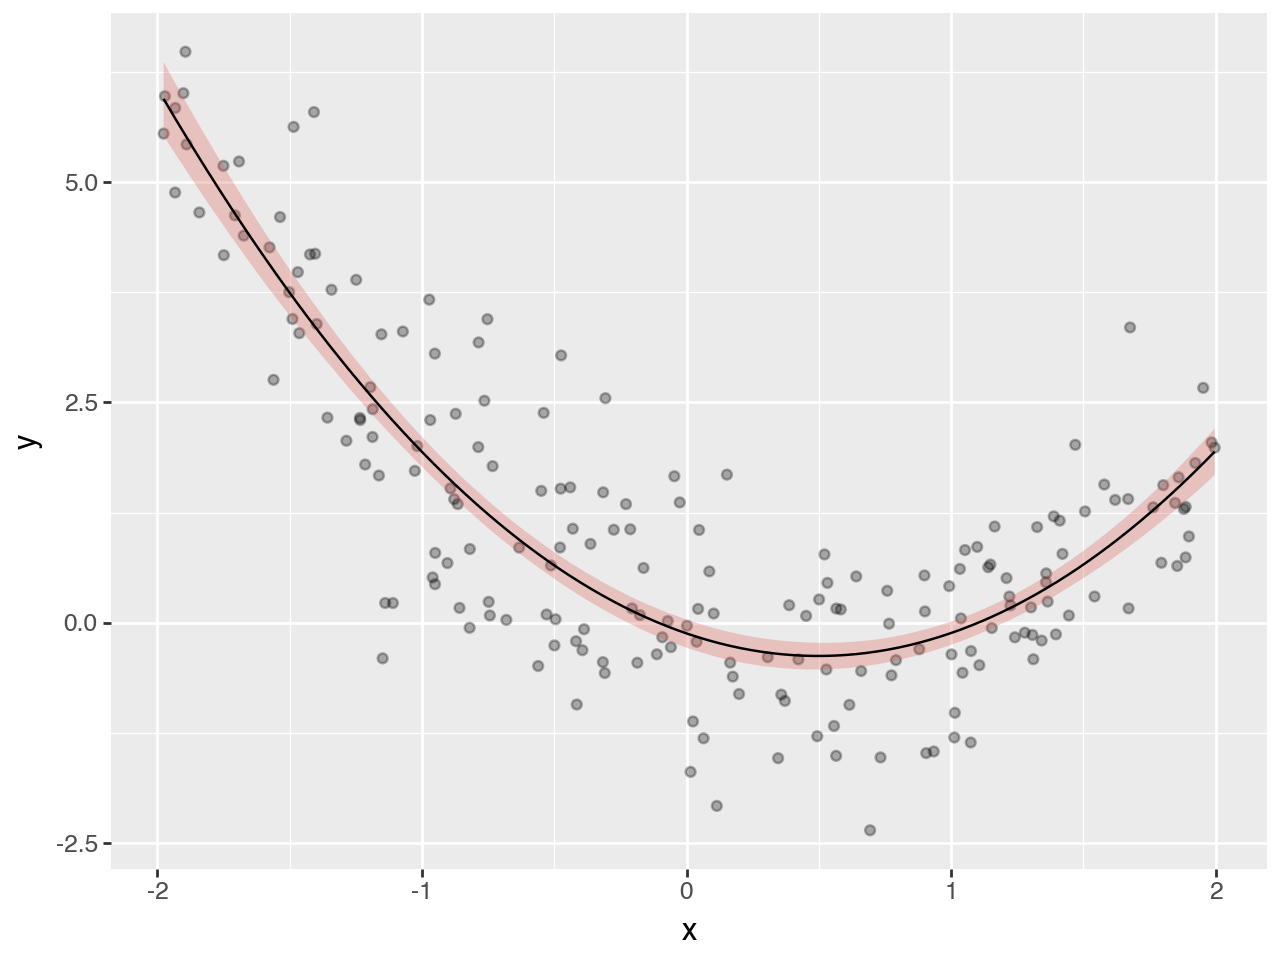

In [16]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.guides(fill="none")
)

### Plot average posterior predictive distribution

In [17]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
mu_sigma_df = (
    predictions_summary[select][["variable", "mean", "x"]]
    .pivot(index="x", columns=["variable"], values="mean")
    .reset_index()
)

mu_sigma_df["low"] = mu_sigma_df["$\\mu$"] - mu_sigma_df["$\\sigma$"]
mu_sigma_df["high"] = mu_sigma_df["$\\mu$"] + mu_sigma_df["$\\sigma$"]
mu_sigma_df

variable,x,$\mu$,$\sigma$,low,high
0,-1.976702,5.942883,1.199779,4.743104,7.142662
1,-1.963415,5.875216,1.197473,4.677744,7.072689
2,-1.950128,5.807920,1.195174,4.612746,7.003094
3,-1.936841,5.740976,1.192879,4.548097,6.933856
4,-1.923554,5.674407,1.190589,4.483818,6.864997
...,...,...,...,...,...
295,1.942956,1.780180,0.693745,1.086435,2.473926
296,1.956243,1.819991,0.692505,1.127486,2.512497
297,1.969530,1.860160,0.691268,1.168892,2.551429
298,1.982817,1.900693,0.690032,1.210661,2.590724


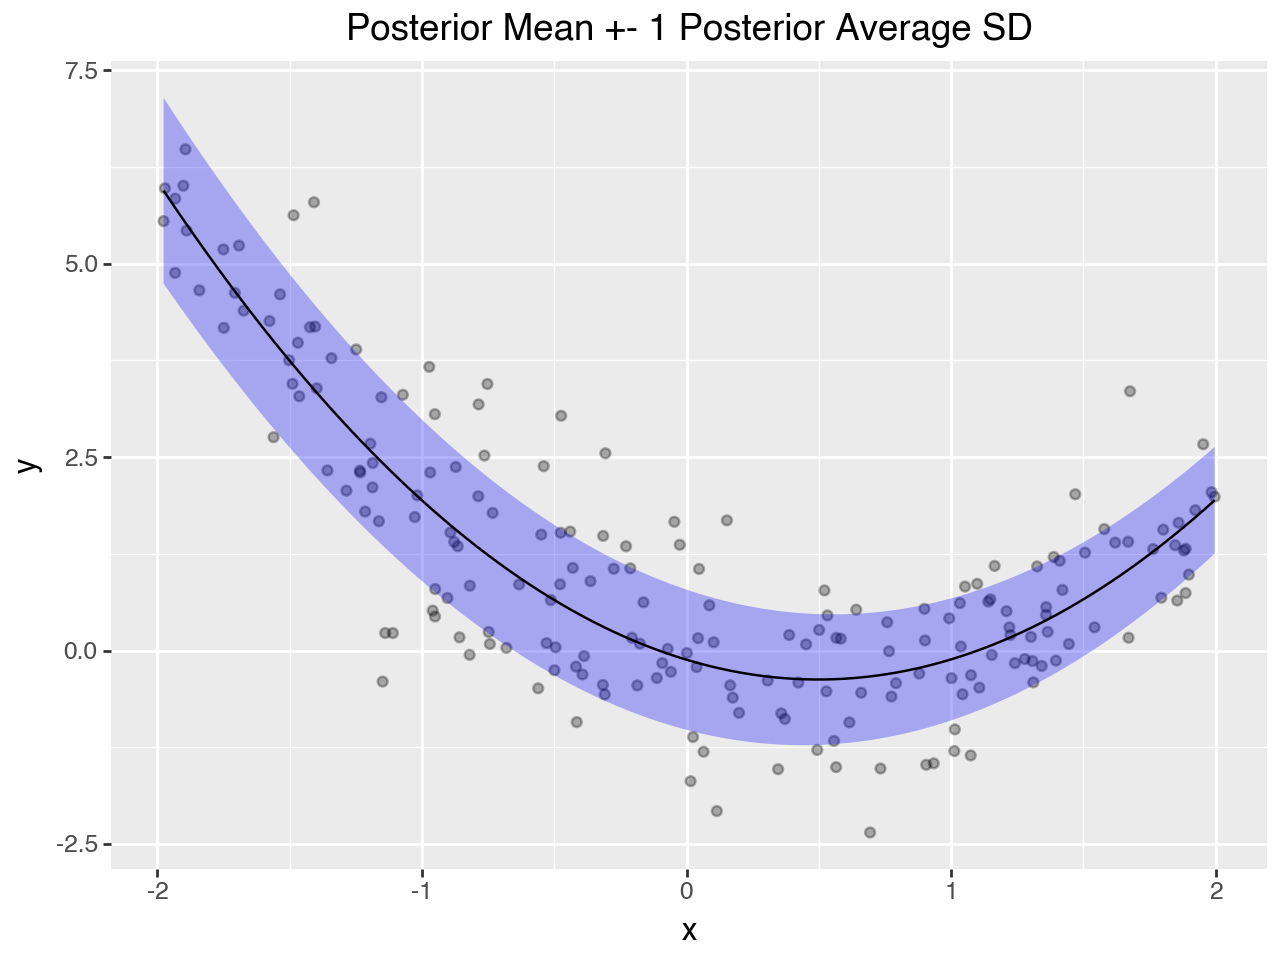

In [18]:
(
    p9.ggplot()
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="low", ymax="high"),
        alpha=0.3,
        fill="blue",
        data=mu_sigma_df,
    )
    + p9.geom_line(p9.aes("x", "$\\mu$"), data=mu_sigma_df)
    + p9.labs(title="Posterior Mean +- 1 Posterior Average SD")
    + p9.guides(fill="none")
)

## Posterior Predictive Checks

### Draw posterior predictive samples

In [19]:
ppsamples = model.sample(  # new in liesel v0.4.0
    shape=(3,), seed=jax.random.key(1), posterior_samples=samples
)

ppsamples["y"].shape

(3, 4, 1000, 200)

In [20]:
# can be reshaped to concatenate the first two axes
_ = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])

### Summarize posterior predictive samples

In [21]:
ppsamples = model.sample(
    shape=(),  # just draw 1 value for each posterior sample
    seed=jax.random.key(1),
    posterior_samples=samples,
)

# summarise ppsamples
ppsamples_summary = gs.SamplesSummary(ppsamples).to_dataframe().reset_index()

# add covariate to df
ppsamples_summary["x"] = df["x"].to_numpy()

### Plot posterior predictive summary

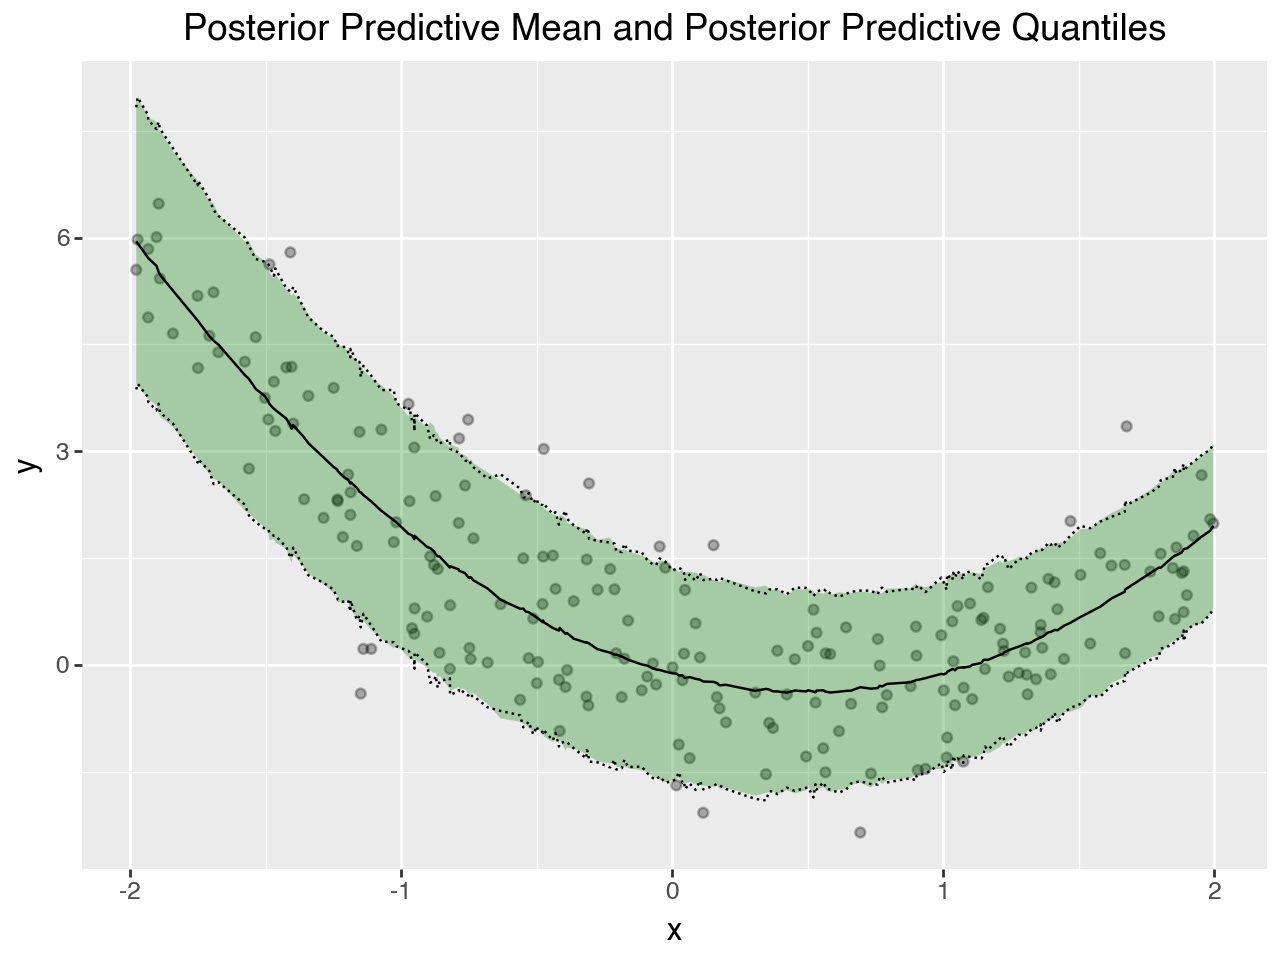

In [22]:
(
    p9.ggplot(ppsamples_summary)
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
    )
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.labs(title="Posterior Predictive Mean and Posterior Predictive Quantiles")
    + p9.guides(fill="none")
)

### Plot posterior predictive samples

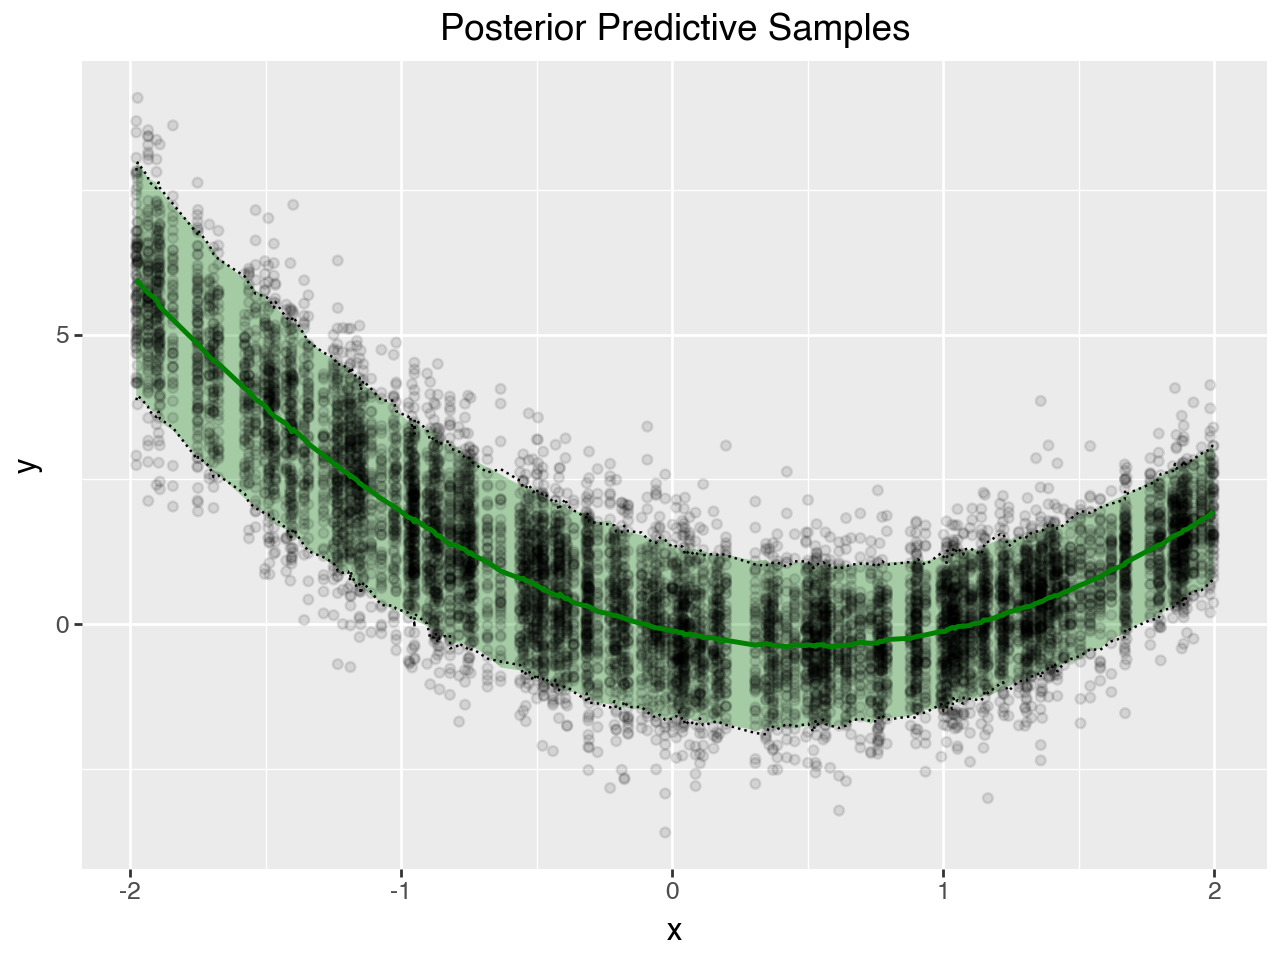

In [23]:
ppsamples_reshaped = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])
ppsamples_df = pd.DataFrame(ppsamples_reshaped.T)
ppsamples_df["x"] = df["x"].to_numpy()
ppsamples_df = ppsamples_df.melt(id_vars=["x"], value_name="y", var_name="sample")
ppsamples_df[ppsamples_df["sample"].isin(range(5))]


nsamples = 50


(
    p9.ggplot(ppsamples_df[ppsamples_df["sample"].isin(range(nsamples))])
    + p9.labs(title="Posterior Predictive Samples")
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
        data=ppsamples_summary,
    )
    + p9.geom_point(p9.aes("x", "y"), alpha=0.1)
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "mean"), color="green", size=1, data=ppsamples_summary)
)